# Leaderboard Probing

In this notebook, I show you how to complete Leaderboard Probing by 18 submissions. <br>
I didn't even think I could identify private and public division before reading [this great discussion](https://www.kaggle.com/c/indoor-location-navigation/discussion/240176), so our team didn't use this result to our valid submission during the competition. Thank you for giving me the opportunity to learn about Leaderboard Proving.<br>

I don't know this way is same as the way Tom's team did, so if you know a more efficient way, please let me know!!<br>

This method may be obvious to those who are familiar with Kaggle, but I hope it will be useful for beginners like me.

#### There were some typo in old version and filenames.
#### ・"proving" -> "probing"
#### ・"100" -> "10", "101" -> "11"
#### Sorry...

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# set all floors to 10
def get_preped():
    sub = pd.read_csv("../input/indoor-location-navigation/sample_submission.csv")
    tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
    sub['site'] = tmp[0]
    sub['path'] = tmp[1]
    sub['timestamp'] = tmp[2].astype(int)
    sub["x"] = 0
    sub["y"] = 0
    sub["floor"] = 10
    return sub.copy()

## Get a base score [1 sub]

In [ ]:
sub = get_preped()
sub[["site_path_timestamp", "floor", "x", "y"]].to_csv(f"LeaderboardProving_base.csv", index=False)    

Result:<br>


## Check the effective digit of LB [1 sub]

In [ ]:
sub["floor"] = 11111111111111111
sub[["site_path_timestamp", "floor", "x", "y"]].to_csv("check_digit.csv", index=False)

Result:<br>
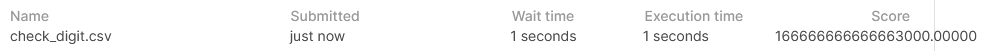

The length of effective digit is 15.

## Get public information by setting floors to power of 2 [16 subs]
You can find out which floor is public at the same time by setting their floor to 4, 8, 16, .....<br>
(You can set them from 1, but it will be troublesome due to the error.) <br>

For example, suppose that if you get the floor wrong by 1, the public will be worse off by exactly 1.
Pick one of several paths and change their floors to 4, 8, 16, 32, ..., and if LB degrades by 36(=4+32), then the paths changed to 4 and 32 will be included in the publication.
In other words, for inputs that do not interfere with each other, the original input is restored from the output.

In [ ]:
beki = []
for i in range(10000):
    if (1 << i) > 1e12:
        break
    else:
        beki.append(1<<i)
L = len(beki)
L

You can check 40 paths at the same time in this way.

In [ ]:
for i in range(100):
    sub = get_preped()
    paths = sub.path.unique()
    
    # add 4, 8, ... to i*L, i*L+1, ... (i+1)*L-1th floors
    if (i+1)*L <= len(paths):
        change_path = paths[i*L: (i+1)*L]
    elif i*L >= len(paths):
        break
    else:
        change_path = paths[i*L:]
    
    for j, path in enumerate(change_path):
        idx = sub[sub.path==path].index[0]
        sub.loc[idx, "floor"] += beki[j] * 4
    sub[["site_path_timestamp", "floor", "x", "y"]].to_csv(f"LeaderboardProving_retry_{i}.csv", index=False)    

Result:<br>
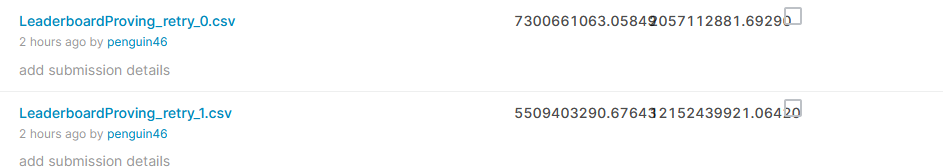
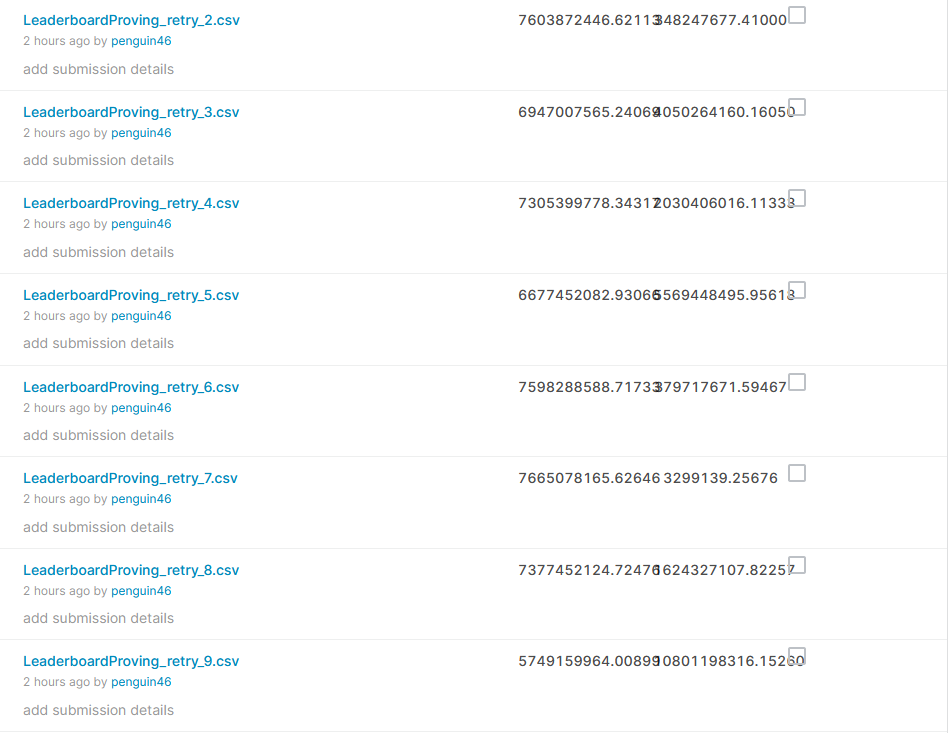
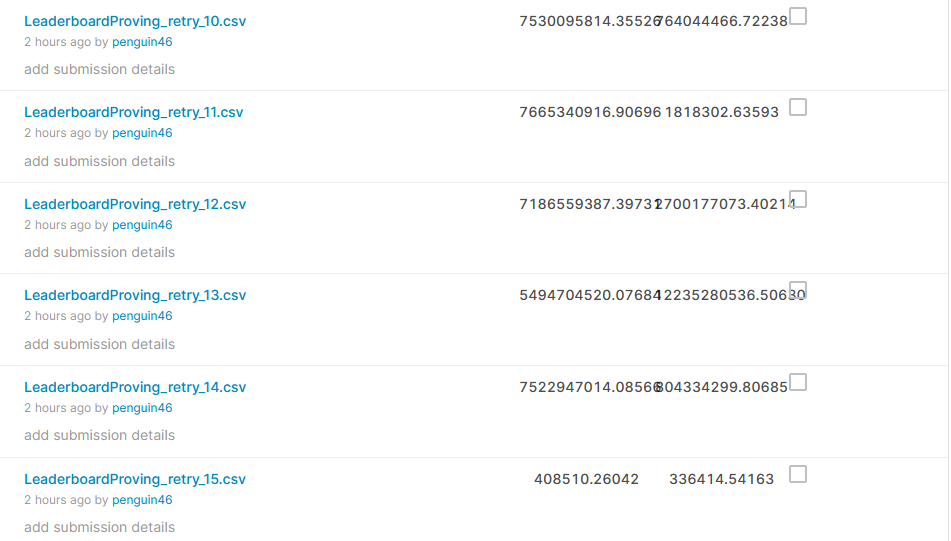

In [ ]:
# Please note that, during the contest, you can only see up to three decimal places, 
# so you need to round off the fourth decimal place of the score above. 
proved = np.array([
    2057112881.693,
    12152439921.064,
    348247677.410,
    4050264160.161,
    2030406016.113,
    5569448495.956,
    379717671.595,
    3299139.257,
    1624327107.823,
    10801198316.153,
    764044466.722,
    1818302.636,
    2700177073.402,
    12235280536.506,
    804334299.807,
    336414.542,
])

In [ ]:
base_score = 285.033
proved -= base_score # only floor loss

## Identify the number of rows in Public
The loss excluding the coordinate part should be an integer multiple of 15 divided by the number of rows (single_loss). Therefore, if the floor loss divided by single_loss is close enough to an integer, we know that it is the true number of rows.

In [ ]:
len(sub) * 0.15

In [ ]:
losses = []
for n_public in range(1500, 1550): # about 1519.95
    loss = 0
    single_loss = 15 / n_public
    for p in proved:
        l = p % single_loss
        loss += min(l, single_loss-l)
    
    losses.append(loss)   
losses = np.array(losses)
n_public = losses.argmin()+1500
n_public

In [ ]:
losses

Since the loss is clearly smaller at 1527(0.00429461), we know that the number of rows in public is 1527!

## Identify the path contained in public
This can be done by using the method explained earlier, replacing 15/1527 with the effect on the LB when you make a mistake of 1 floor.

In [ ]:
sub = get_preped()
paths = sub.path.unique()

n_public_row = 0 # for debug
public_paths = []
single_loss = 15 / n_public  
nxt = 0 # index of the next path
for p in proved:  
    # get bits
    public_bits = bin(int(round((p) / single_loss)))[::-1][2:-2] # remove head and tail ("00", "0b")
    print(public_bits)
    
    ## please comment out if you want to check original bits.
    ## you can find the last two digits are 0 (because we multiple 4 to avoid error).
    # print(f"check: {bin(int(round((p) / single_loss)))}")
    
    for b in public_bits:
        if b == "1": # in public
            public_paths.append(paths[nxt])
            n_public_row += len(sub[sub.path==paths[nxt]])
        nxt += 1
    nxt += L - len(public_bits)

In [ ]:
# Make sure that the number of lines in public is 1527
n_public_row

### Check

In [ ]:
sub = get_preped()
for p in public_paths:
    sub.loc[sub.path==p, "floor"] += 1
sub[["site_path_timestamp", "floor", "x", "y"]].to_csv(f"LeaderboardProving_public101_private100.csv", index=False)  

Result:<br>
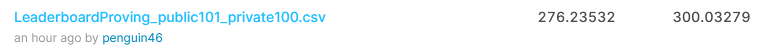

Base score:<br>


public has increased by 15, indicating that Leaderboard Probing was a success!<br>
Thank you for reading!!